In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import correlate

In [3]:
df =  pd.read_csv("./jikkenr160_0902.csv", header = 0, skiprows = 6)
sw =  pd.read_csv("./r160_f80_f02_P81newsweep.csv",names=('x', 'y'))

In [4]:
df['X(mm)'] = df['X']*1000.0
df['Y(mm)'] = df['Y']*1000.0
df['Z(mm)'] = df['Z']*1000.0

9692


Text(0, 0.5, 'x, y [mm]')

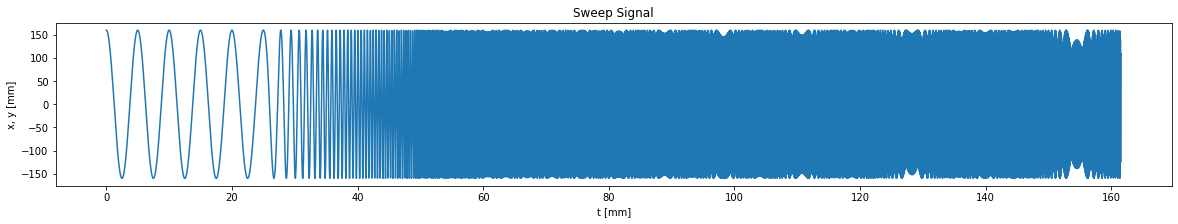

In [5]:
fps_sweep = 60
n=len(sw['x'])
print(n)
t=np.linspace(0,n,n)/fps_sweep
plt.figure(figsize=(20,3))
plt.plot(t,sw['x'])
plt.title('Sweep Signal')
plt.xlabel('t [mm]')
plt.ylabel('x, y [mm]')

Text(0, 0.5, 'Frequency [Hz]')

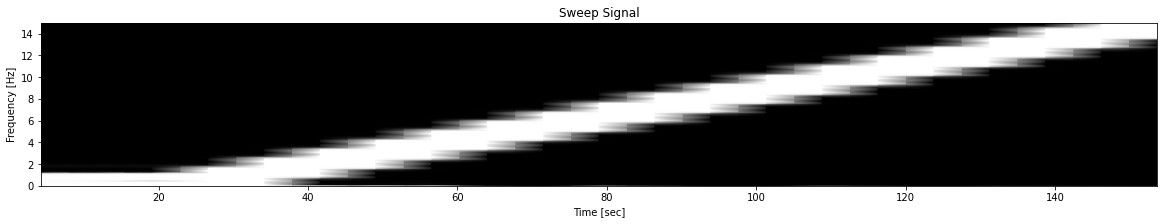

In [6]:
plt.figure(figsize=(20,3))
f,t_,Sxx = signal.spectrogram(sw['x'], fps_sweep, nperseg=512)
ax = plt.gca()
ax.pcolormesh(t_, f, Sxx,vmax=1e+1, vmin=1e-17, shading='gouraud', cmap='gray') #coolwarm jet gray 
ax.set_ylim([0,fps_sweep/4])
plt.title('Sweep Signal')
ax.set_xlabel(u'Time [sec]')
ax.set_ylabel(u'Frequency [Hz]')

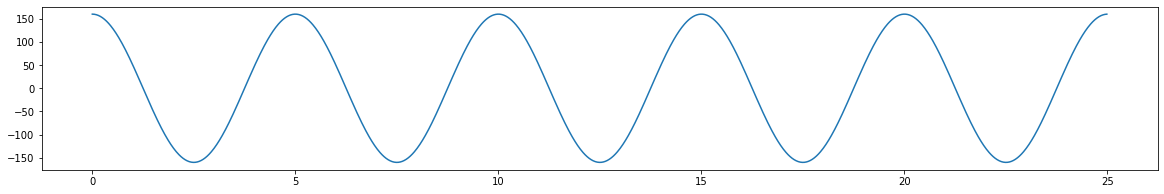

In [7]:
plt.figure(figsize=(20,3))
cx = df['X(mm)'] - np.mean(df['X(mm)'])
cy = sw['x'][:fps_sweep * 5 * 5] - np.mean(sw['x'][:fps_sweep * 5 * 5])
ct = t[:fps_sweep * 5 * 5]
plt.plot(ct,cy)

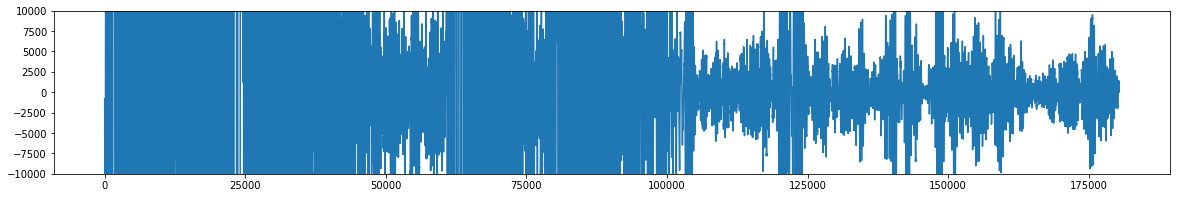

In [8]:
plt.figure(figsize=(20,3))
plt.plot(correlate( cx, cy))
plt.ylim([-10000,10000])
plt.show()

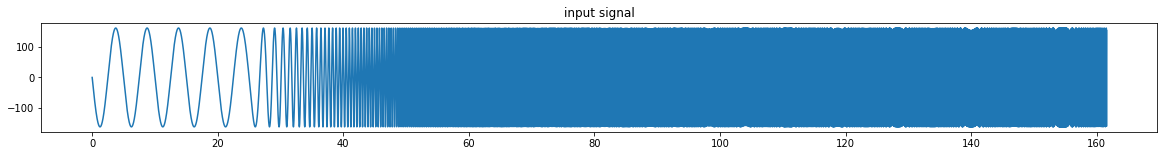

In [9]:
r = 160 # [mm]

f_max =       8  #  Hz
f_min =     0.2  #  Hz
dulation_s = 25  # s

fps_opti =   120 # Hz

ns = fps_opti * dulation_s 
n  = 8196 * 2         # 8196 @ 60 fps = 8196 * 2 @ 120fps 

delta_f = (f_max - f_min) / n

t1 = np.linspace(0, ns, ns) / fps_opti
t2 = np.linspace(0, n, n) / fps_opti + dulation_s
tsx = np.append(t1,t2)
# (単位円の半径r)*(PI)*(時刻tにおける振動数f)*(時刻t)
sx120=[]
sx120 = -r * np.sin(2.0 * np.pi *  f_min * tsx[:ns])
sx120s= -r * np.sin(2.0 * np.pi * (f_min + delta_f * np.linspace(0,n,n)) * np.linspace(0,n,n)/fps_opti)
sx120 = np.append(sx120, sx120s)
plt.figure(figsize=(20,2))
plt.plot(tsx, sx120)
plt.title('input signal')
plt.show()

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

        
def setname(i):
    # implemented from 
    # https://github.com/maeda-lab/Scaledown/blob/master/simulation/simulation_realtime_Ji_sending/Source.cpp

    # Order of names created... 1/4xy,yz,zx 1/8xy,yz,zx  1/16xy,yz,zx
    # by using "if" ,"%",and "/"
    
    name = 'scale_'

    # C++ source might have bug
    # the following arrangement should be correct
    # Masahiro Furukawa
    if i % 3 == 0:
        space = "xy" 
        movespace = 0
    elif i % 3 == 1:
        space = "yz"
        movespace = 1
    else:
        space = "zx"
        movespace = 2

    if int(i / 3) == 0: 
        scalesize = "1_4"
        scale = 0.25
        c = 'g'
    elif int(i / 3) == 1:
        scalesize = "1_8"
        scale = 0.125
        c = 'r'
    else:
        scalesize = "1_16"
        scale = 0.0625
        c = 'b'

    return (name + scalesize + space , scale, c)

In [11]:
def Coordination_Opti2Robot(x,y,z):
    
    #    Robot : +X(to Front), +Y(to Left), +Z(to Top)
    # **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
    
    return (z, x, y)

def prep_axis(ax, str, ssx, ssy, ssn, key_x):
    ax.plot(ssx, ssy, ssn, 'k.', alpha=0.2, label= key_x, markersize=1)
    ax.plot(ssx, ssn, 'k.', zdir='y', zs= 80  ,alpha=0.1, markersize=1)
    ax.plot(ssy, ssn, 'k.', zdir='x', zs=-80  ,alpha=0.1, markersize=1)
    ax.plot(ssx, ssy, 'k.', zdir='z', zs=-80  ,alpha=0.1, markersize=1)        
    ax.set_xlabel('Arm Position X [mm]')
    ax.set_ylabel('Arm Position Y [mm]')
    ax.set_zlabel('Arm Position Z [mm]')
    ax.set_xlim([-80, 80])
    ax.set_ylim([-80, 80])
    ax.set_zlim([-80, 80])
    ax.legend([str])

In [12]:
def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 
    n = len(df[key_x])
    t = np.linspace(0,n,n)/fps_opti
    print(n)
    
    deltaSec = 160
    plotSec = 10
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (no re-scaled)', fontsize=30)
    
    for s in range(nTrial):
        
        str,_,_ = setname(s)
        
        (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])
        
        plt.subplot(3,3,s+1)
        plt.plot(t, z,'b-',alpha=0.9,label = key_z, markersize=3)
        plt.plot(t, x,'r-',alpha=0.9,label = key_x, markersize=3)
        plt.plot(t, y,'g-',alpha=0.9,label = key_y, markersize=3)
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
#         plt.ylim([0,10])
        ts = start_in_sec[s]
        te = start_in_sec[s+1]
        plt.xlim([ts, te])
        plt.legend()
        plt.grid(True)
    
    plt.show()

    
    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (no re-scaled)', fontsize=30)
    
    for s in range(nTrial):
        
        str, scale, c = setname(s)
        
        skip_sec = 150
        draw_sec = 10
        
        ss = ( start_in_sec[s] + skip_sec ) * fps_opti
        es = ss + draw_sec * fps_opti
        # es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) )
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) 
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) )
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax = fig.add_subplot(331+s, projection='3d')
        
        ax.plot(x, y, z, c, alpha=0.7)
        
        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)


        sx = sw['x'][:plotSec*fps_opti] * scale
        sy = sw['y'][:plotSec*fps_opti] * scale    
        sn = np.zeros(len(sx))
        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy

        prep_axis(ax, str, ssx, ssy, ssn, key_x)

    fig = plt.figure(figsize=(20,15))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (RE-SCALED)', fontsize=30)
    
    for s in range(nTrial):
        
        str, scale, c = setname(s)
        
        ss = start_in_sec[s]   *fps_opti
        es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax = fig.add_subplot(331+s, projection='3d')
        
        ax.plot(x, y, z, c, alpha=0.7)
        
        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)
        
        sx = sw['x'][:plotSec*fps_opti]  / 4.0
        sy = sw['y'][:plotSec*fps_opti]  / 4.0
        sn = np.zeros(len(sx))

        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy
        
        prep_axis(ax, str, ssx, ssy, ssn, key_x)
    fig = plt.figure(figsize=(10,7))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (RE-SCALED)', fontsize=30)
    
    ax = fig.add_subplot(111, projection='3d')
    
    for s in [0,3,6]:
        
        str, scale, c = setname(s)
        
        ss = start_in_sec[s]   *fps_opti
        es = start_in_sec[s+1] *fps_opti
        
        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)
        
        ax.plot(x, y, z, c, alpha=0.6, label=str)

        ax.plot(x, z, 'k-', zdir='y', zs= 80  ,alpha=0.2, c=c)
        ax.plot(y, z, 'k-', zdir='x', zs=-80  ,alpha=0.2, c=c)
        ax.plot(x, y, 'k-', zdir='z', zs=-80  ,alpha=0.2, c=c)

        sx = sw['x'][:plotSec*fps_opti] / 4.0
        sy = sw['y'][:plotSec*fps_opti] / 4.0
        sn = np.zeros(len(sx))
        
        if 'xy' in str:
            ssx = sx
            ssy = sy
            ssn = sn
            
        if 'yz' in str:
            ssx = sn
            ssy = sx
            ssn = sy

        if 'zx' in str:
            ssx = sx
            ssy = sn
            ssn = sy       

        prep_axis(ax, str, ssx, ssy, ssn, key_x)

    plt.tight_layout()
    plt.show()
    

178928


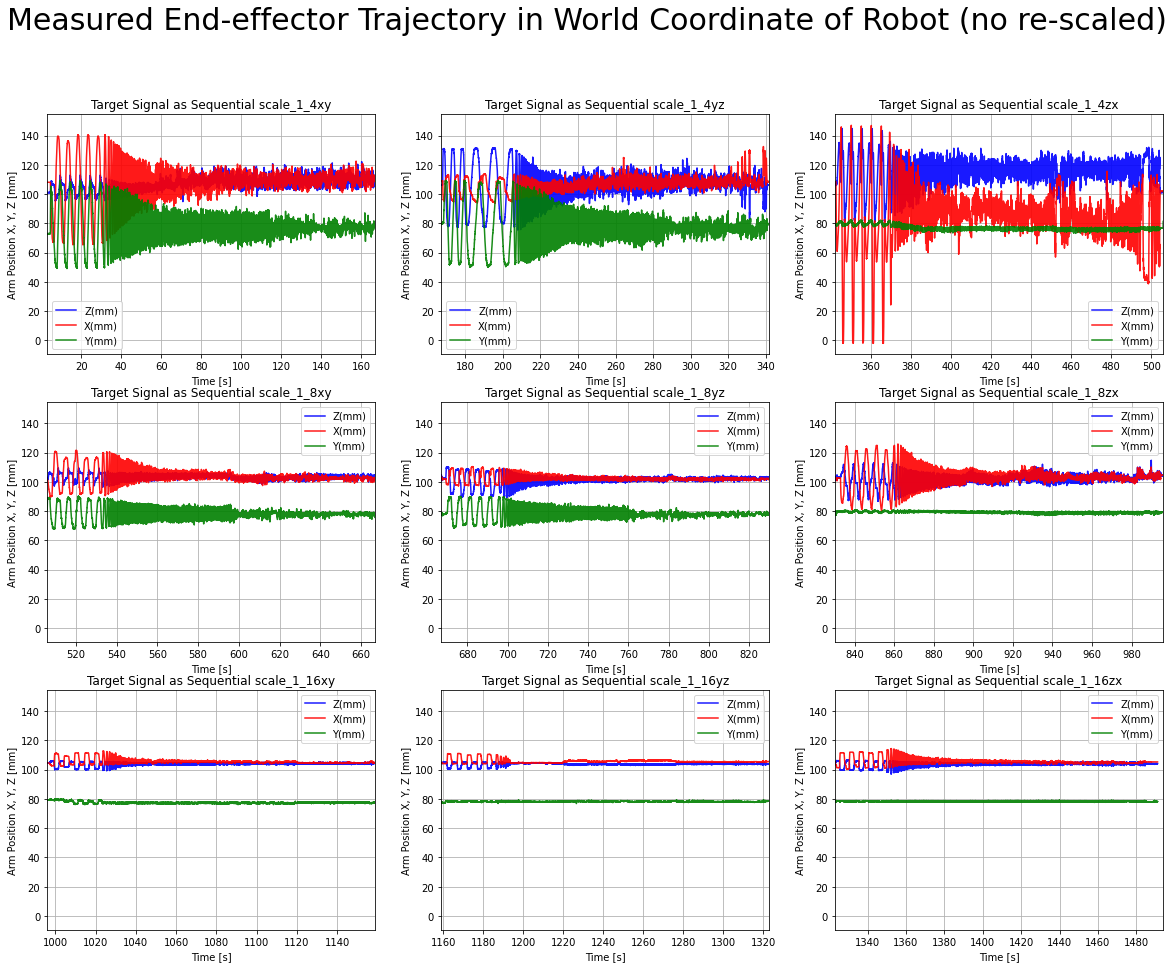

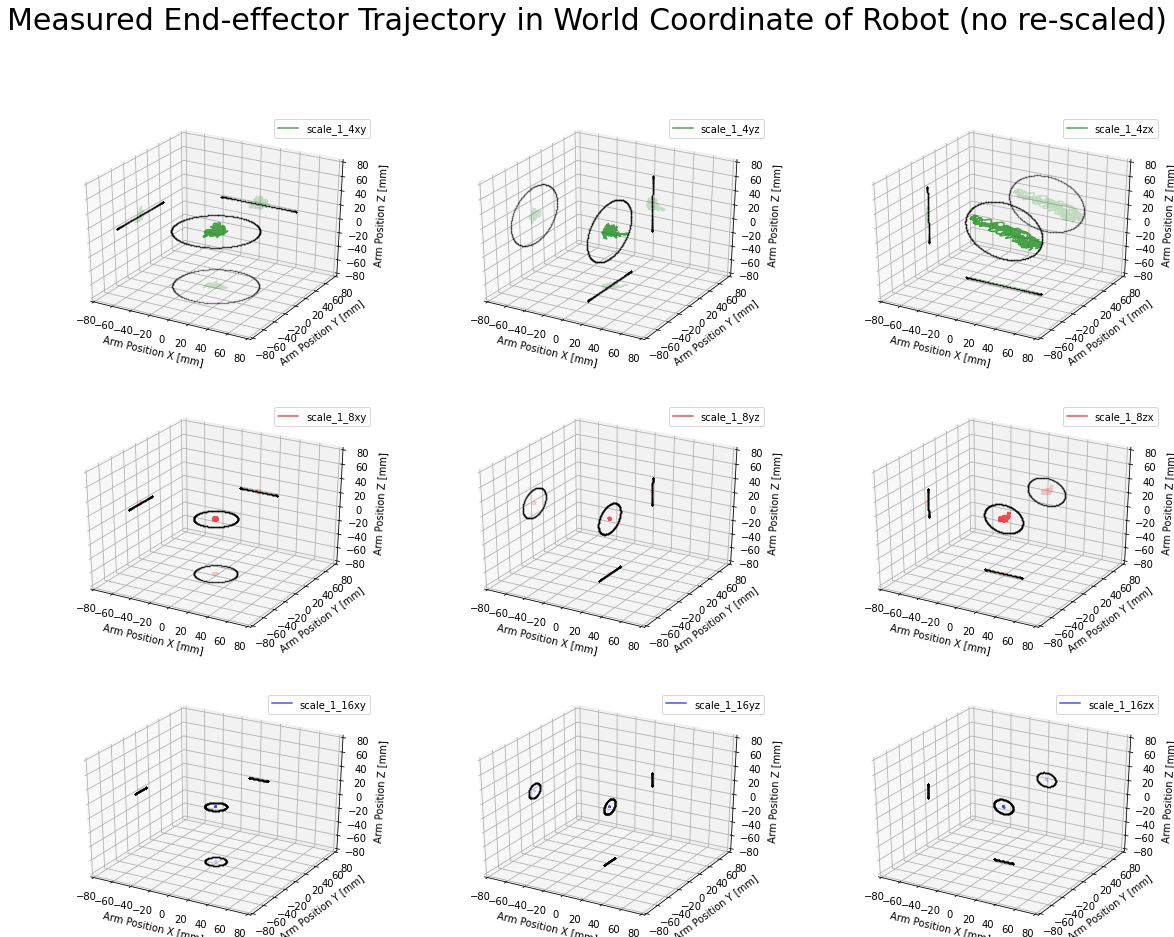

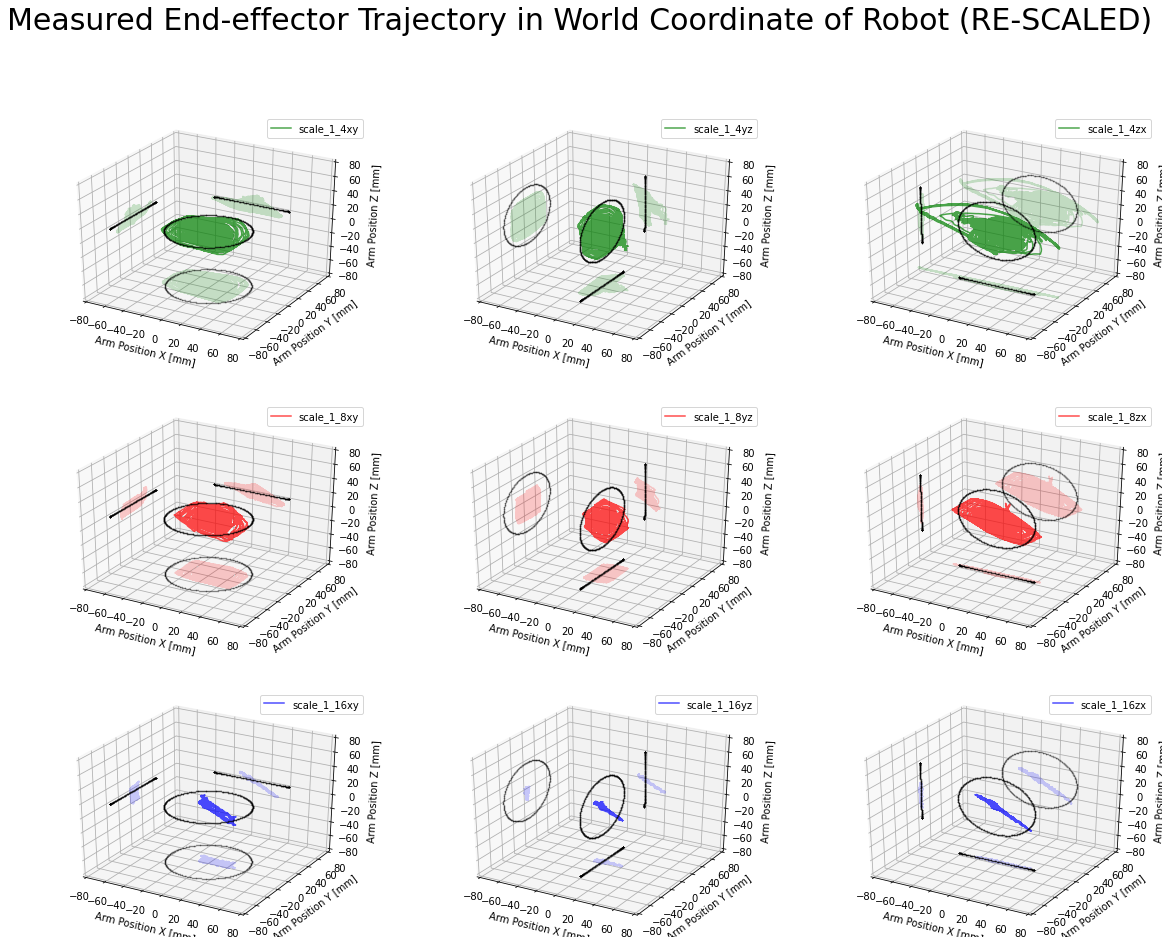

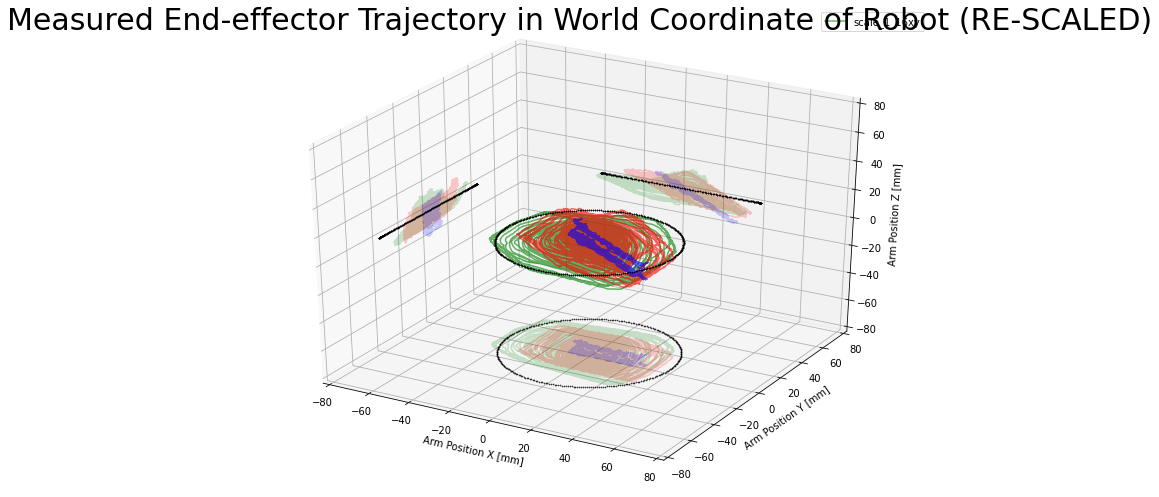

In [13]:
start_in_sec = [3, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

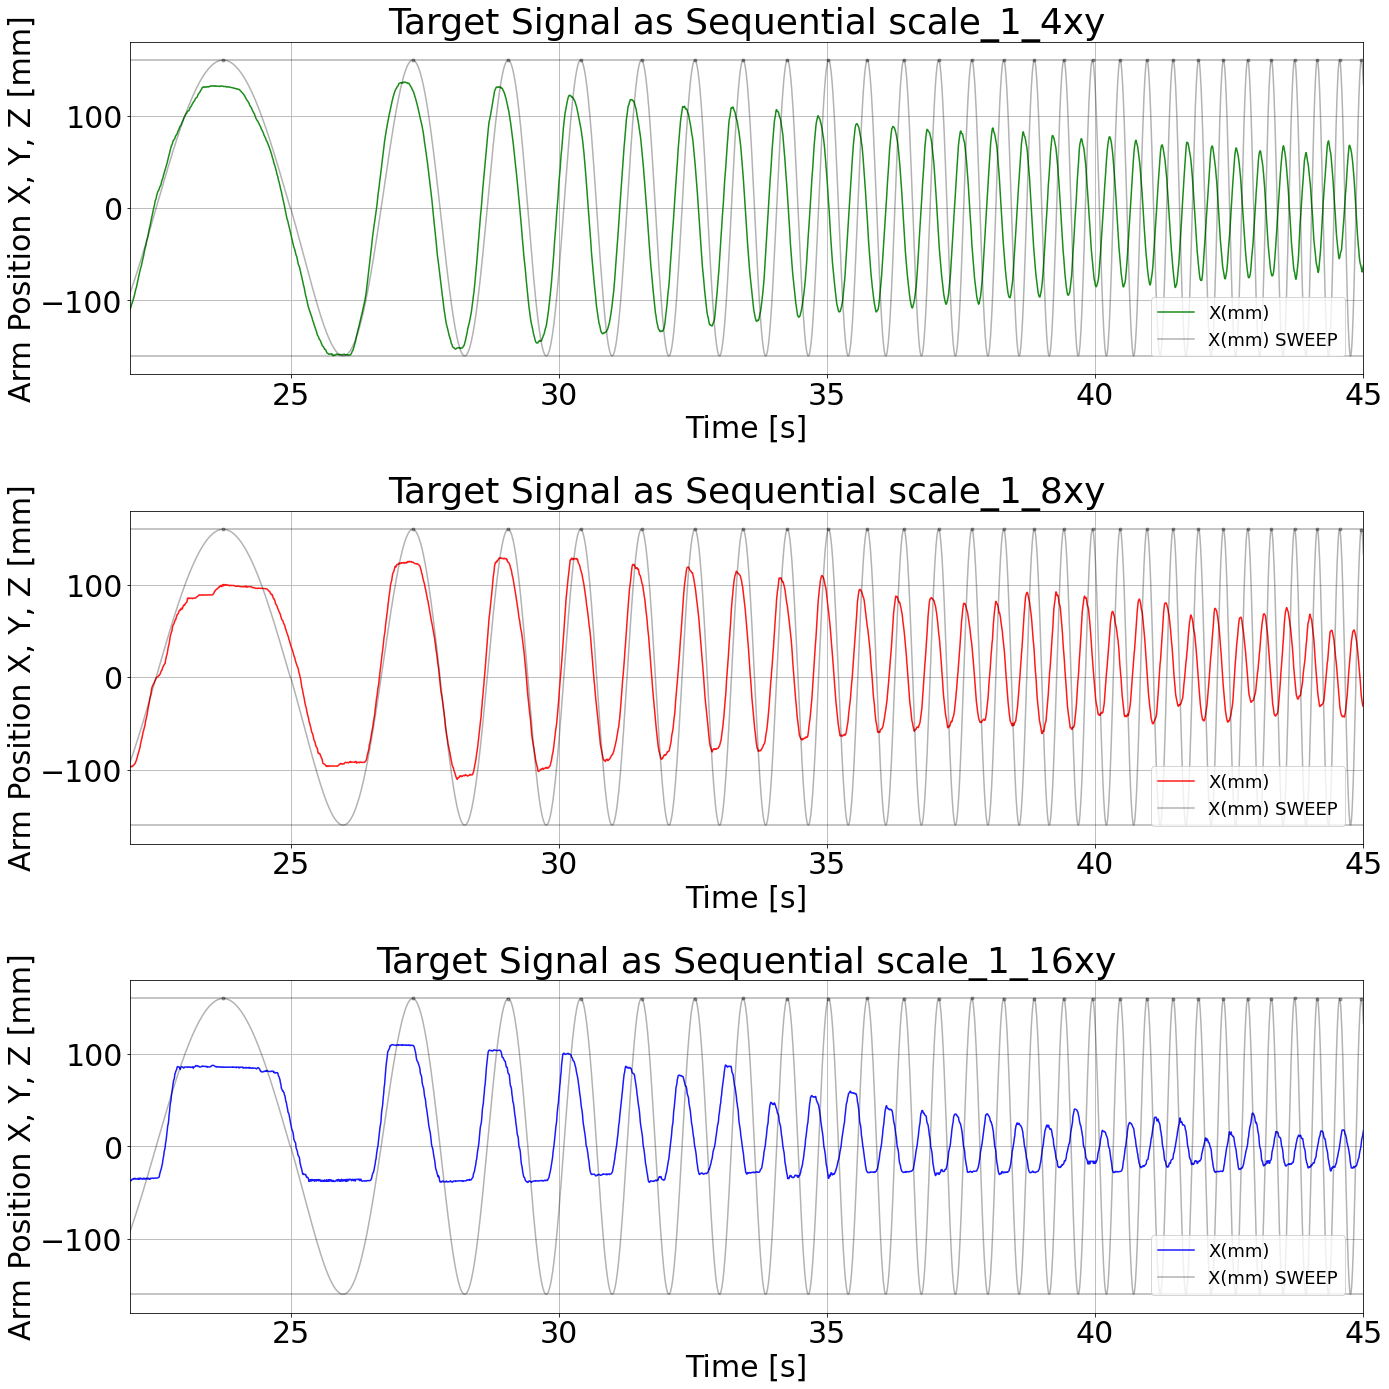

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import find_peaks
from scipy.signal import correlate

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
def Coordination_Opti2Robot(x,y,z):
    return (z, x, y)

def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 120
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    #fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])

    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        
        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(sx120),len(sx120))/fps_opti
        
        peaks_xx, _ = find_peaks(xx,    distance=40)
        peaks_sx, _ = find_peaks(sx120, distance=40)
#         acf = correlate(x,x)[acTSec*fs:]

        plt.subplot(3,1,int(s/3)+1)
    
        for i, pi in enumerate(peaks_sx):
            if i == 0 or pi > 6000: 
                continue
                
            w = int((peaks_sx[i] - peaks_sx[i-1])/1.5)
            pis = -w + peaks_sx[i-1]
            pie =  w + peaks_sx[i-1]
        plt.rcParams["font.size"] = 30
        if(s==0):
            plt.plot(t+mod_in_sec[s]           , xx/(scale),                   'g-', alpha=0.9, label = key_x,          markersize=2)
        elif(s==3):
            plt.plot(t+mod_in_sec[s]           , xx/(scale),                   'r-', alpha=0.9, label = key_x,          markersize=2)
        elif(s==6):
            plt.plot(t+mod_in_sec[s]           , xx/(scale),                   'b-', alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , sx120,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        plt.plot(ts[peaks_sx], sx120[peaks_sx],'ko', alpha=0.3,                         markersize=3)
        
        plt.plot([mod_in_sec[s],len(xx)/fps_opti+mod_in_sec[s]],[160,160], 'k-',alpha=0.3,markersize=3)
        plt.plot([mod_in_sec[s],len(xx)/fps_opti+mod_in_sec[s]],[-160,-160], 'k-',alpha=0.3,markersize=3)
        
        plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=18)
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-180,180])
        plt.grid(True)

   
    plt.tight_layout()
    plt.show()
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

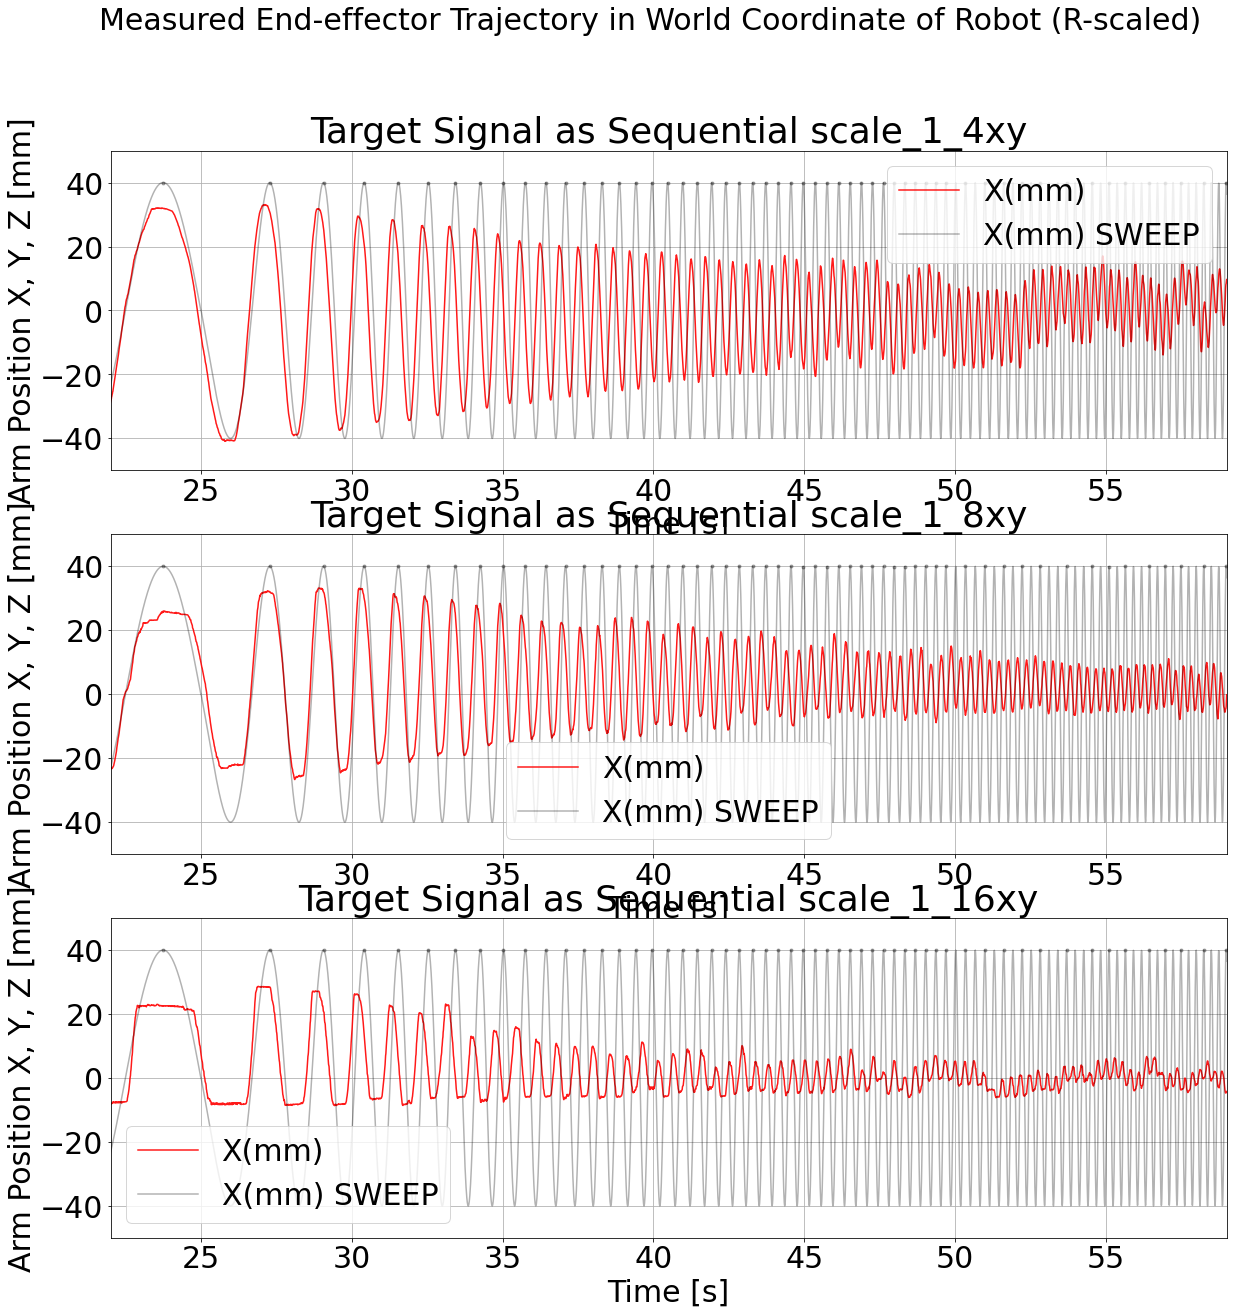

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import find_peaks
from scipy.signal import correlate

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
def Coordination_Opti2Robot(x,y,z):
    return (z, x, y)

def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])

    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        
        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(sx120),len(sx120))/fps_opti
        
        peaks_xx, _ = find_peaks(xx,    distance=40)
        peaks_sx, _ = find_peaks(sx120, distance=40)
#         acf = correlate(x,x)[acTSec*fs:]

        plt.subplot(3,1,int(s/3)+1)
    
        for i, pi in enumerate(peaks_sx):
            if i == 0 or pi > 6000: 
                continue
                
            w = int((peaks_sx[i] - peaks_sx[i-1])/1.5)
            pis = -w + peaks_sx[i-1]
            pie =  w + peaks_sx[i-1]
#             cor = correlate(xx[pis:pie], sx120[pis:pie])
#             ic = np.argmax(cor)
            
#             plt.figure()
#             plt.plot(cor)
#             plt.plot(ic, cor[ic], 'bo', alpha=0.9, markersize=6)
#             print(i,pi,peaks_sx[i] - peaks_sx[i-1],t[pis],t[pie])
#             plt.plot(t[ic+pis] ,xx[ic+pis], 'bo', alpha=0.9, markersize=6)
#             plt.hlines(t[pis]/10-20, t[pis], t[pie], 'gray', alpha=0.9) # **
#             print(i, cor[i], cor)

#             if i == 1: 
#                 dfix = ts[ic]
            
#         plt.plot(t           , xx,                   'r-', alpha=0.9, label = key_x,          markersize=2)
#         plt.plot(ts          , sx120*scale,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
#         plt.plot(ts[peaks_sx], sx120[peaks_sx]*scale,'ko', alpha=0.3,                         markersize=3)

        plt.plot(t+mod_in_sec[s]           , xx/(4*scale),                   'r-', alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , sx120/4,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        plt.plot(ts[peaks_sx], sx120[peaks_sx]/4,'ko', alpha=0.3,                         markersize=3)
        
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-50,50])
        plt.legend()
        plt.grid(True)


#     plt.tight_layout()
    plt.show()
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

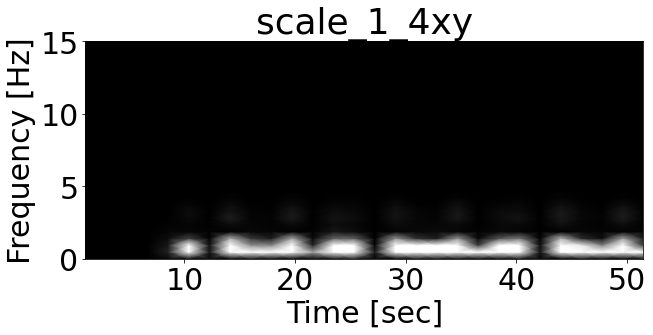

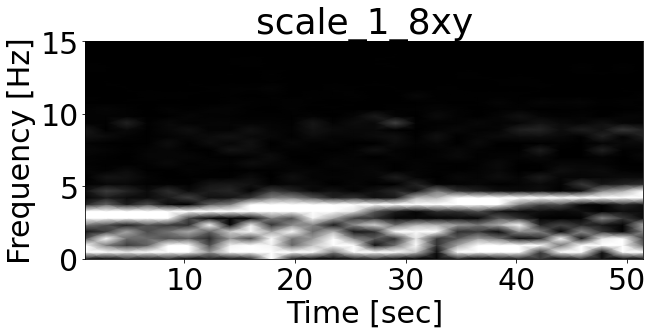

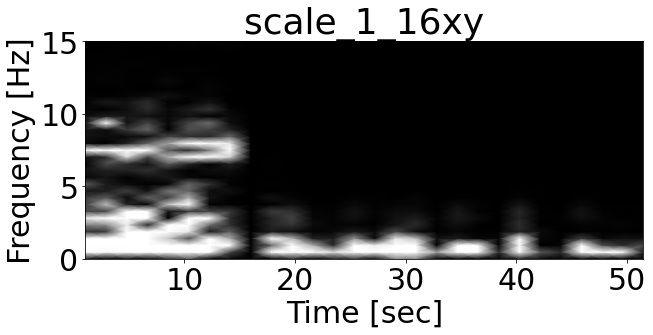

In [17]:
# Masahiro Furukawa
# Aug 31, 2020

# Spectrogram

## coding:utf-8
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import fftpack

def plot_Spec(key_x, key_y, key_z):
    
    for s in [0,3,6]:

        fps_opti = 60
        deltaSec = 53
        
        str, scale, c = setname(s)

        ss = s*deltaSec*fps_opti
        es = (s+1)*deltaSec*fps_opti

        x = ( df[key_x][ss:es] - np.mean(df[key_x][ss:es]) ) / scale / 4.0
        y = ( df[key_y][ss:es] - np.mean(df[key_y][ss:es]) ) / scale / 4.0
        z = ( df[key_z][ss:es] - np.mean(df[key_z][ss:es]) ) / scale / 4.0
        
        (x,y,z) = Coordination_Opti2Robot(x,y,z)

        fig = plt.figure(figsize=(10,4))

        vmx = [1e-9, 5*1e-7]
        vmn = [1e-11, 1e-8]

        # spectrogram
        f,t_,Sxx = signal.spectrogram(x, fps_opti, nperseg=128)
        ax = plt.gca()
        ax.pcolormesh(t_, f, Sxx,vmax=1e+1, vmin=1e-17, shading='gouraud', cmap='gray') #coolwarm jet gray 
        # ax.set_xlim([150,400])
        ax.set_ylim([0,fps_opti/4])
        ax.set_title(str)
        ax.set_xlabel(u'Time [sec]')
        ax.set_ylabel(u'Frequency [Hz]')

plot_Spec('X(mm)', 'Y(mm)', 'Z(mm)')

-1.8816592728398973e-10
19392
0
19410
[5120, 5145, 5172, 3106, 5224, 5248, 3352, 5298, 3528, 5346, 3676, 5394, 3805, 5442, 3917, 5489, 4019, 5533, 4113, 5577, 4204, 5622, 4287, 5665, 4367, 5708, 4443, 5750, 4515, 5791, 4585, 5833, 4652, 5874, 4716, 5912, 4778, 5952, 4840, 5991, 4899, 6029, 4956, 6068, 5012, 6105, 5066, 6142, 5120, 6179, 5172, 6215, 5224, 6254, 5274, 6289, 5323, 6325, 5372, 6361, 5419, 6394, 5465, 6427, 5512, 6462, 5556, 6496, 5600, 6530, 5644, 6563, 5689, 6596, 5730, 6628, 5772, 6660, 5812, 6693, 5854, 6708, 5893, 6754, 5933, 6785, 5973, 6817, 6012, 6849, 6050, 6880, 6088, 6908, 6124, 6938, 6162, 6955, 6198, 7000, 6234, 7028, 6271, 7056, 6307, 7086, 6342, 7101, 6377, 7145, 6411, 7173, 6445, 7199, 6480, 7228, 6513, 7258, 6545, 7285, 6580, 7311, 6612, 7339, 6644, 7367, 6676, 7395, 6708, 7421, 6740, 7462, 6771, 7487, 6803, 7502, 6832, 7555, 6864, 7580, 6894, 7607, 6925, 7631, 6955, 7684, 6983, 7709, 7014, 7758, 7043, 7772, 7073, 7810, 7101, 7821, 7128, 7871, 7159, 7882, 7

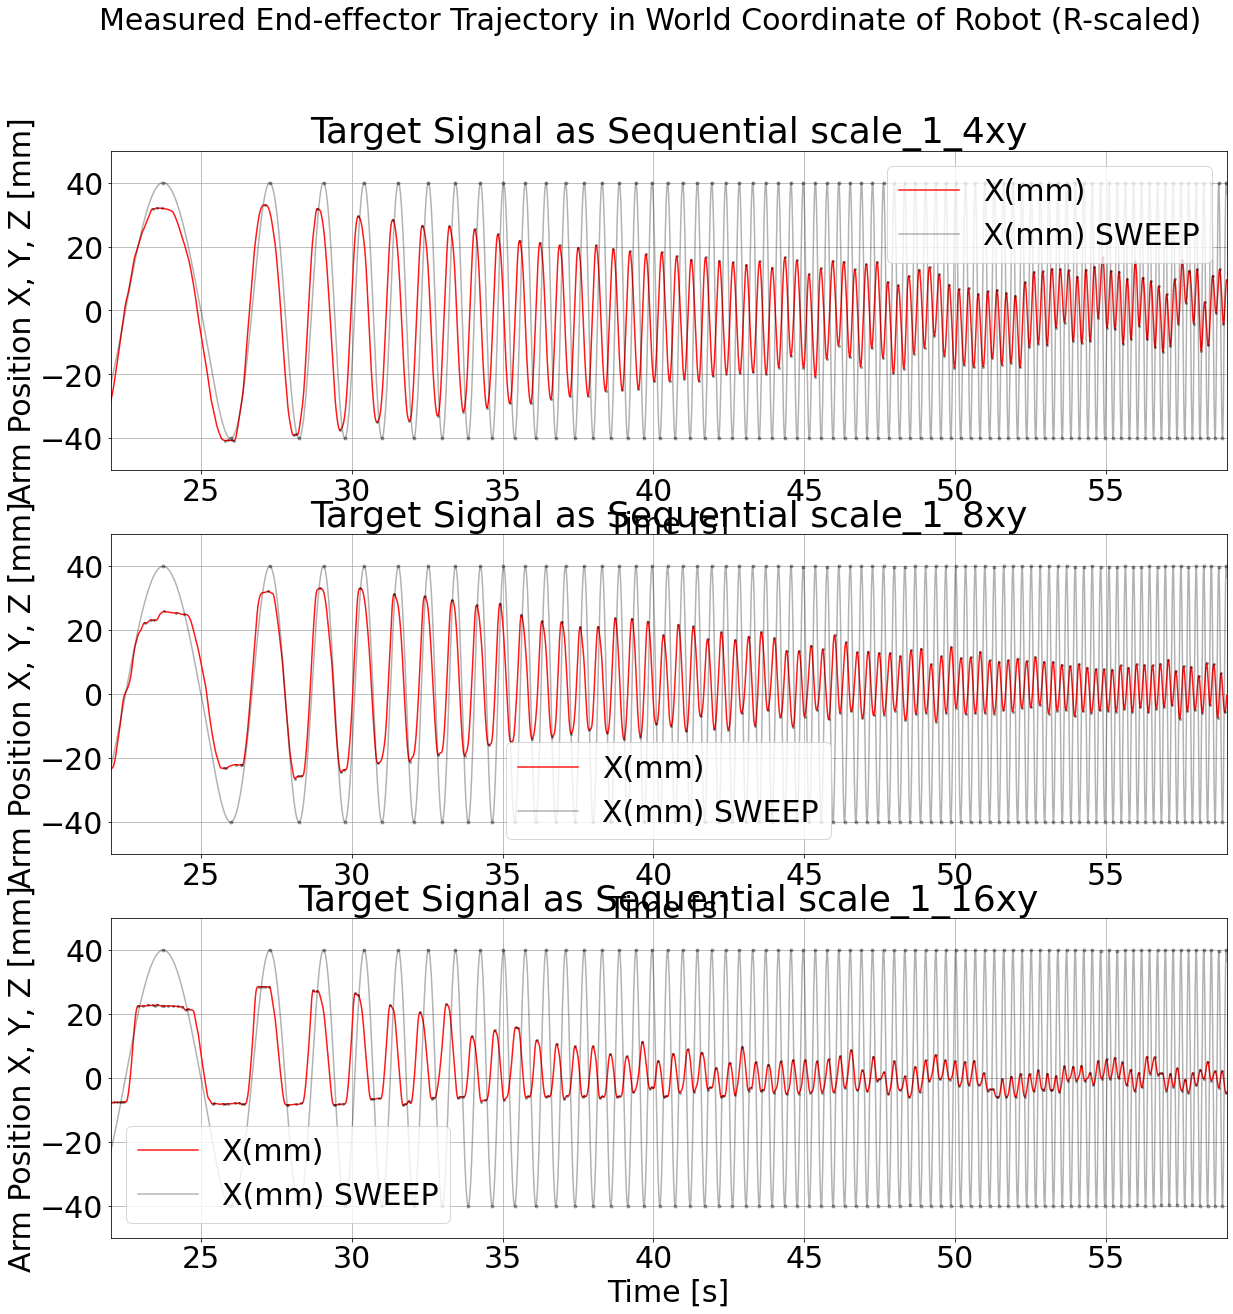

In [18]:
# 2020 09 08 TomokiHirayama
# 2020 09 11 TomokiHirayama    create peaks
# 2020 09 13 TomokiHirayama    create function :set_clear

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)


#バターワースフィルタ（ローパス）https://watlab-blog.com/2019/04/30/scipy-lowpass/
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す

#周波数解析
def plot_analyze_x(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])

    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        # xx : axis-x data
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        
        #offsetとローパス
        offset=sum(xx)
        print(offset)
        xx=xx-offset
        xx = xx/(4*scale)
        gpass=3
        gstop=40
        xx=lowpass(xx,fps_opti , f_max, f_max*0.5, gpass, gstop)
        
        
        # ys : time data
        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(sx120),len(sx120))/fps_opti
        
        #peaks_xx, _ = find_peaks(xx,    distance=40)
        #peaks_sx, _ = find_peaks(sx120, distance=1)

        #極大極小を探す
        max_xx = signal.argrelmax(xx, order=1)
        min_xx = signal.argrelmin(xx, order=20)
        max_sx = signal.argrelmax(sx120, order=1)
        min_sx = signal.argrelmin(sx120, order=1)
        #合体
        peaks_xx=np.sort(np.hstack((max_xx,min_xx)))
        peaks_sx=np.sort(np.hstack((max_sx,min_sx)))


        #print(peaks_xx)

        #peaks_xx = set_clear(ts,xx,peaks_xx)


        remain_list=[]# make remain list :  number(peaks_xx)
        #
        threshold = 3.0#閾値，閾値より小さい場合は極致とみなさない
        start_i=0
        end_i=0
        len_ts=len(ts)
        pxsize=len(peaks_xx[0])
        print(len_ts)
        for tmp in range(pxsize):
          #if 
            if (peaks_xx[0][tmp]>len_ts):
        #        #print(peaks_xx[0][tmp])
        #        #print("break")
                break        
            elif(ts[peaks_xx[0][tmp]]<25.0):# if befor 25.0 , there is no using data
                a=1 
            elif( (xx[peaks_xx[0][tmp+1]] - xx[peaks_xx[0][tmp]])> threshold):
        #        #remain_list=np.append(remain_list,int(peaks_xx[0][tmp]))
                remain_list.append(int(peaks_xx[0][tmp]))
            elif( (xx[peaks_xx[0][tmp+1]] - xx[peaks_xx[0][tmp]])< threshold):
                start_i=tmp
                for cnt in range(int(pxsize/10)):
                    if(tmp+cnt+1>=pxsize):
                        end_i=tmp+cnt
                        break;
                    elif((xx[peaks_xx[0][tmp+cnt+1]] - xx[peaks_xx[0][tmp+cnt]])> threshold):
                        end_i=tmp+cnt
                if(end_i-start_i==1):
                    #remain_list=np.append(remain_list,int(peaks_xx[0][start_i]))
                    remain_list.append(int(peaks_xx[0][start_i]))
                    start_i=0
                    end_i=0
                else:
                    #remain_list=np.append(remain_list,int(peaks_xx[0][int((start_i+end_i)/2)]))
                    #if (peaks_xx[0][tmp]>len_ts):
                    #    end_i=end_i-1
                    remain_list.append(int(peaks_xx[0][int((start_i+end_i)/2)]))
                    start_i=0
                    end_i=0
        #remain_list.remove(19410)
        for iii in remain_list:
            if(iii>len_ts):
                print(s)
                print(iii)
                remain_list.remove(iii)

        print(remain_list)
        #remain_list=np.array(int(remain_list))
        plt.subplot(3,1,int(s/3)+1)
        plt.plot(t+mod_in_sec[s]           , xx,            'r-',        alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , sx120/4,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        
        plt.plot(t[peaks_xx]+mod_in_sec[s] , xx[peaks_xx], 'ko', alpha=0.3, markersize=2)
        plt.plot(ts[peaks_sx],               sx120[peaks_sx]/4,      'ko', alpha=0.3, markersize=3)
        #plt.plot(t[remain_list]+mod_in_sec[s] , xx[remain_list], 'ko', alpha=0.3, markersize=2)
        #plt.plot(ts[remain_list],               sx120[remain_list]/4,      'ko', alpha=0.3, markersize=3)
        
        #plt.plot(t[max_xx]+mod_in_sec[s] , xx[max_xx]/(4*scale), 'ko', alpha=0.3, markersize=2)
        #plt.plot(t[min_xx]+mod_in_sec[s] , xx[min_xx]/(4*scale), 'ko', alpha=0.3, markersize=2)
        
        #plt.plot(ts[max_sx],               sx120[max_sx]/4,      'ko', alpha=0.3, markersize=3)
        #plt.plot(ts[min_sx],               sx120[min_sx]/4,      'ko', alpha=0.3, markersize=3)

        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-50,50])
        plt.legend()
        plt.grid(True)
        remain_list.clear
#     plt.tight_layout()
    plt.show()


plot_analyze_x('X(mm)', 'Y(mm)', 'Z(mm)')

14400
14400
14400
14400
14400
14400


<Figure size 1440x1440 with 0 Axes>

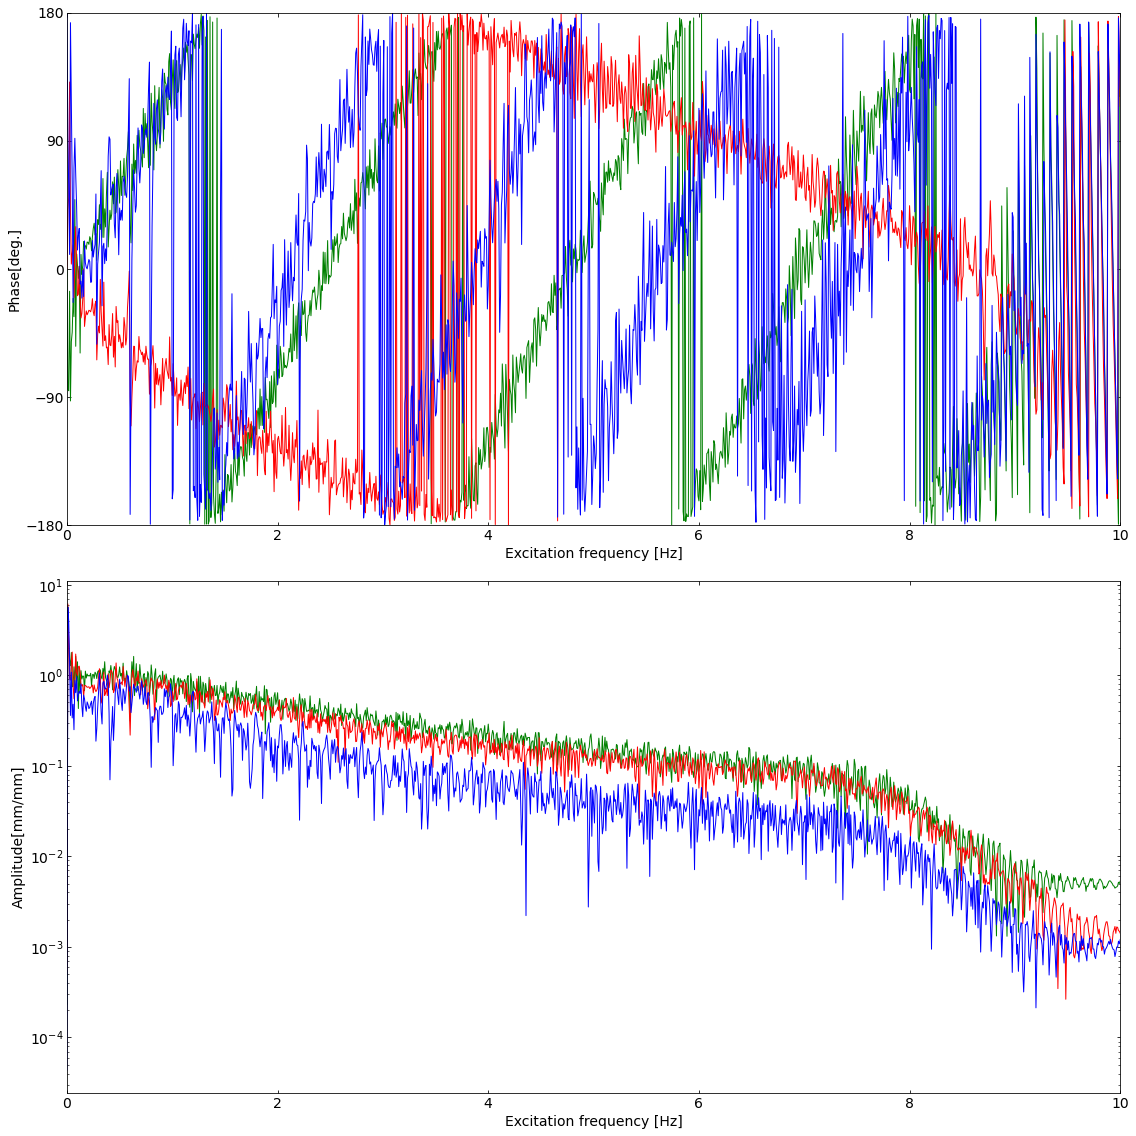

In [82]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import find_peaks
from scipy.signal import correlate
#バターワースフィルタ（ローパス）
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す


# 周波数応答関数(FRF)を計算する関数
def frf(input, output, samplerate):
    fft_i = fftpack.fft(input)                          # 入力信号のフーリエ変換
    fft_o = fftpack.fft(output)                         # 出力信号のフーリエ変換
 
    # FRFを計算
    h_io = (fft_o * fft_i.conjugate()) / (fft_i * fft_i.conjugate())
 
    amp = np.sqrt((h_io.real ** 2) + (h_io.imag ** 2))  # FRFの振幅成分
    #amp = amp / (len(input) / 2)                        # 振幅成分の正規化（辻褄合わせ）
    phase = np.arctan2(h_io.imag, h_io.real)            # 位相を計算
    phase = np.degrees(phase)                           # 位相をラジアンから度に変換
    freq = np.linspace(0, samplerate, len(input))       # 周波数軸を作成
    return h_io, amp, phase, freq

#define wave's start Point by using sec.
start_in_sec = [5, 167, 166*2+10, 166*3+8, 166*4+3, 166*5, 166*6+1, 166*7-3, 166*8-5, 166*9] # correct @ 120fps
mod_in_sec = [.2, 0, 0, -.3, 0, 0, .15, 0, 0]

#    Robot : +X(to Front), +Y(to Left), +Z(to Top)
# **  Opti : +Z(to Front), +X(to Left), +Y(to Top)
def Coordination_Opti2Robot(x,y,z):
    return (z, x, y)

def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 120#162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    #fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])
    gpass=3
    gstop=40
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Times New Roman'
 
    # 目盛を内側にする。
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
 
    # グラフの上下左右に目盛線を付ける。
    fig = plt.figure(figsize=(16.0, 16.0))
        
    ax3 = fig.add_subplot(211)
    ax3.yaxis.set_ticks_position('both')
    ax3.xaxis.set_ticks_position('both')
    ax4 = fig.add_subplot(212)
    ax4.yaxis.set_ticks_position('both')
    ax4.xaxis.set_ticks_position('both')
 
    # 軸のラベルを設定する。
    ax3.set_xlabel('Excitation frequency [Hz]')
    ax3.set_ylabel('Phase[deg.]')
    ax4.set_xlabel('Excitation frequency [Hz]')
    ax4.set_ylabel('Amplitude[mm/mm]')
 
    # スケールの設定をする。
    ax3.set_xticks(np.arange(0, 20, 2))
    ax3.set_xlim(0, 10)
    ax3.set_yticks(np.arange(-270, 270, 90))
    ax3.set_ylim(-180, 180)
    ax4.set_xticks(np.arange(0, 20, 2))
    ax4.set_xlim(0, 10)
    ax4.set_yscale('log')
 
    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        xx = list(x[ts*fps_opti : te*fps_opti])
        xx = xx - np.mean(xx)
        xx=lowpass(xx,fps_opti , f_max,f_max+f_max*0.5 , gpass, gstop)
        xx=xx/scale
        #ssxx120=list(sx120[5*fps_opti : (5+deltaSec)*fps_opti])
        ssxx120=list(sx120[0 : len(xx)])
        
        print(len(xx))
        print(len(ssxx120))


        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(ssxx120),len(ssxx120))/fps_opti
        

#         acf = correlate(x,x)[acTSec*fs:]]
        dt=1/120.0
        h_io, amp, phase, freq = frf(ssxx120, xx, 1 / dt)



 
        # データプロットの準備とともに、ラベルと線の太さ、凡例の設置を行う。

        if(s==0):
            ax3.plot(freq, phase, lw=1,color='green')
            ax4.plot(freq, amp, lw=1,color='green')
        elif(s==3):
            ax3.plot(freq, phase, lw=1,color='red')
            ax4.plot(freq, amp, lw=1,color='red')
        elif(s==6):
            ax3.plot(freq,phase, lw=1,color='blue')
            ax4.plot(freq, amp, lw=1,color='blue')
    # レイアウト設定
    fig.tight_layout()
    plt.show()
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')

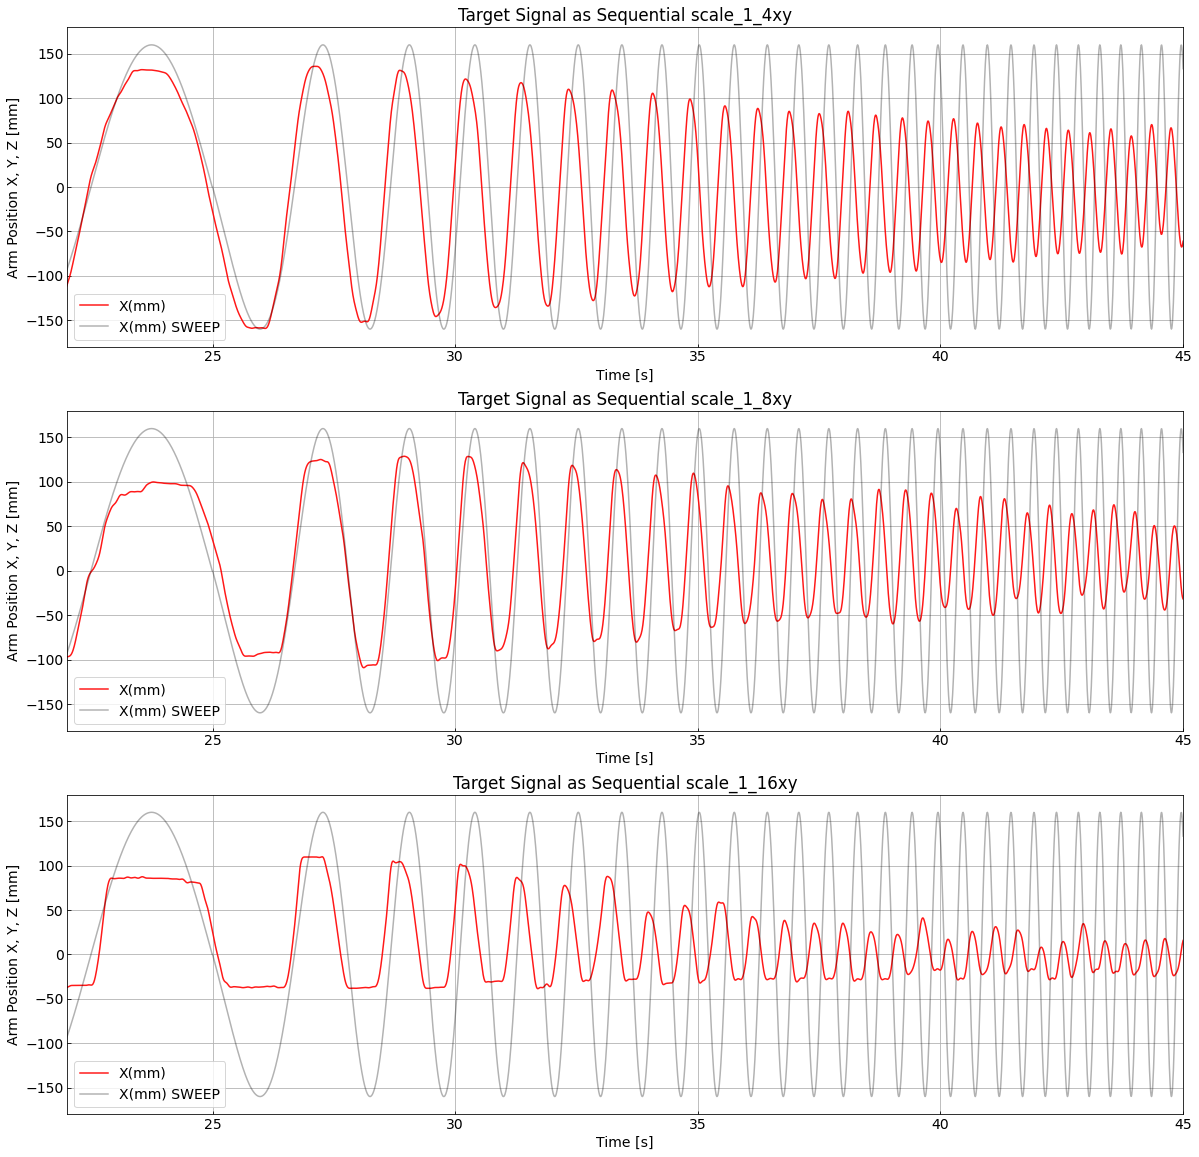

In [71]:
def Coordination_Opti2Robot(x,y,z):
    return (z, x, y)

def plot_One(key_x, key_y, key_z):   
    
    fps_opti = 120 #opti data's fps
    n = len(df[key_x])  #length of Opti data 
    t = np.linspace(0,n,n+1)/fps_opti #make array 0~n ( num = n)
    
    deltaSec = 120#162
    
    nTrial = int(n/deltaSec/fps_opti)
 
    alpha = 0.2
    
    fig = plt.figure(figsize=(20,20))
    #fig.suptitle('Measured End-effector Trajectory in World Coordinate of Robot (R-scaled)', fontsize=30)
    
    (x,y,z) = Coordination_Opti2Robot(df[key_x], df[key_y], df[key_z])
    gpass=3
    gstop=40
    for s in [0, 3, 6]:        
        str, scale,_ = setname(s)

        ts = start_in_sec[s]
        te = ts + deltaSec
        
        xx = list(x[ts*fps_opti : te*fps_opti]/scale)
        xx = xx - np.mean(xx)
        xx=lowpass(xx,fps_opti , f_max, f_max*0.5, gpass, gstop)
        ssxx120=list(sx120[0 : len(xx)])
        #ssxx120=list(sx120[5*fps_opti : (5+deltaSec)*fps_opti])
        
        #print(len(xx))
        #print(len(ssxx120))


        t  = np.linspace(0,len(xx),len(xx))/fps_opti
        ts = np.linspace(0,len(ssxx120),len(ssxx120))/fps_opti
        plt.subplot(3,1,int(s/3)+1)
        plt.plot(t+mod_in_sec[s]           , xx,                   'r-', alpha=0.9, label = key_x,          markersize=2)
        plt.plot(ts          , ssxx120,          'k-', alpha=0.3, label = key_x+' SWEEP', markersize=3)
        #plt.plot(ts[peaks_sx], sx120[peaks_sx],'ko', alpha=0.3,                         markersize=3)
        
        plt.title('Target Signal as Sequential ' + str)
        plt.xlabel('Time [s]')
        plt.ylabel('Arm Position X, Y, Z [mm]')
        plt.xlim([22,deltaSec/3+5])
        plt.ylim([-180,180])
        plt.legend()
        plt.grid(True)


#     plt.tight_layout()
    plt.show()
    
plot_One('X(mm)', 'Y(mm)', 'Z(mm)')